# Assignment2 - Supervised Learning flow

# Part 1 - Student details:
* Please write the First Name and last 4 digits of the i.d. for each student. For example:
<pre>Israel 9812</pre>

In [1]:
# student 1: Yarin 6011
# student 2: Tomer 7081
# student 3: Refael 0246

## Part 2 - Initial Preparations 
You could add as many code cells as needed

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import f1_score,classification_report
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier


## Data Loading - trainset and testset

In [3]:
train_df = pd.read_csv('titanic_train.csv')
train_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,0,54.0,1,0,78.2667,1,1
1,2,0,45.0,0,0,13.5000,0,1
2,3,1,20.0,0,0,9.5000,0,0
3,3,1,36.0,0,0,7.8958,0,0
4,3,1,22.0,0,0,8.0500,0,0


In [4]:
test_df = pd.read_csv('titanic_test.csv')
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,1,35.000000,0,0,7.0500,0,0
1,3,1,30.000000,0,0,7.2500,0,0
2,3,1,29.699118,0,0,14.5000,0,0
3,3,0,21.000000,0,0,7.7500,2,0
4,3,1,32.000000,0,0,56.4958,0,1


## Preprocessing
### Data Cleansing
### Handle duplicated rows

In [5]:
train_num_rows = train_df.shape[0]
print(f"Number of rows in train data frame: {train_num_rows}")

train_df.drop_duplicates(keep='first',inplace=True)
train_df = train_df.reset_index(drop=True)
train_num_rows = train_df.shape[0]

print(f"Number of rows in train data frame after removing duplicated rows is: {train_num_rows}\n")

Number of rows in train data frame: 712
Number of rows in train data frame after removing duplicated rows is: 632



### Handle none values

In [6]:
train_columns_with_none = train_df.columns[train_df.isnull().any()]
for column in train_columns_with_none:
    print(column)

In [7]:
test_columns_with_none = test_df.columns[test_df.isnull().any()]
for column in test_columns_with_none:
    print(column)

## EDA & Feature Engineering

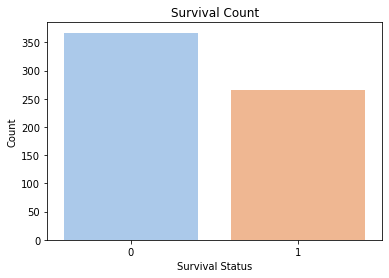

In [8]:
sns.countplot(x='Survived', data=train_df, palette='pastel')
plt.xlabel('Survival Status')
plt.ylabel('Count')
plt.title('Survival Count')
plt.show()

The count plot clearly illustrates that the number of passengers who did not survive exceeds the count of those who survived.


### Viewing all pairs correleations

The following code will display the correlations between each pair of features in the dataset using a heatmap.


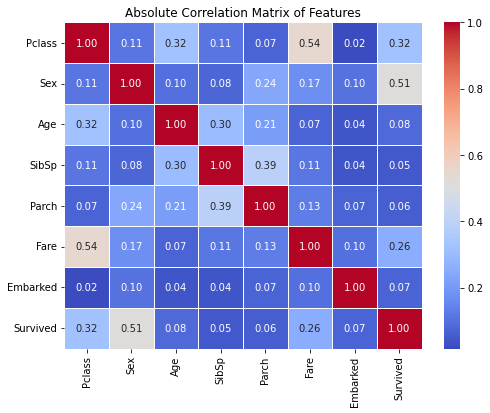

In [9]:
correlation_matrix = train_df.corr()

absolute_correlation_matrix = correlation_matrix.abs()

plt.figure(figsize=(8, 6))
sns.heatmap(absolute_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Absolute Correlation Matrix of Features')
plt.show()


### High Correlation Pairs in Training Data

This section detects and lists pairs of features in the training dataset with a correlation coefficient greater than 0.3, excluding duplicate pairs and self-correlations.


In [10]:
df_train_corr = train_df.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index)

# Training set high correlations
corr = df_train_corr_nd['Correlation Coefficient'] > 0.3
df_train_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
8,Fare,Pclass,0.542995
10,Survived,Sex,0.514598
12,SibSp,Parch,0.391679
14,Pclass,Survived,0.323125
16,Age,Pclass,0.322891
18,Age,SibSp,0.300990


### High Correlation Pairs in Test Data

In [11]:
df_test_corr = test_df.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_test_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_test_corr.drop(df_test_corr.iloc[1::2].index, inplace=True)
df_test_corr_nd = df_test_corr.drop(df_test_corr[df_test_corr['Correlation Coefficient'] == 1.0].index)
# Test set high correlations
corr = df_test_corr_nd['Correlation Coefficient'] > 0.3
df_test_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
8,Pclass,Fare,0.574241
10,Survived,Sex,0.509608
12,Parch,Fare,0.471795
14,SibSp,Parch,0.417181
16,Pclass,Survived,0.395163
18,Age,Pclass,0.388599


After analyzing both the test and training datasets, a significant correlation was found between the 'Pclass' (passenger class) and 'Fare' variables. This makes sense, as first-class passengers generally pay higher fares.

Likewise, the 'Survived' variable, which indicates whether a passenger survived, shows a strong correlation with the 'Sex' attribute.


### Exploring the correlation between the 'Survived' and 'Sex'

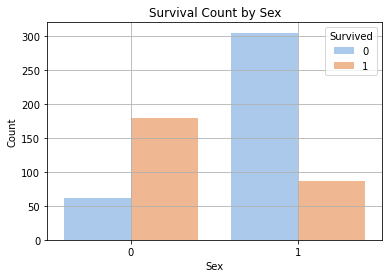

In [12]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Sex', hue='Survived', data=train_df,palette='pastel')
plt.title('Survival Count by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.grid(True)
plt.show()


As shown in the plot above, the survival rate among females significantly exceeds that of males.

In [13]:
train_df[['Sex', 'Survived']].groupby(['Sex'], as_index=True).mean()


,Survived
Sex,
0,0.742739
1,0.219949


### We can improve our dataset by adding a new column that meaningfully combines existing information from other features.

In [14]:
def process_family_size(df):
    df['Family_Size'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = df['Family_Size'].apply(lambda x: 1 if x == 1 else 0)
    df = df.drop(['SibSp', 'Parch', 'Family_Size'], axis=1)
    return df

In [15]:
train_df = process_family_size(train_df)
test_df = process_family_size(test_df)

In [16]:
train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=True).mean()

,Survived
IsAlone,
0,0.500000
1,0.355114


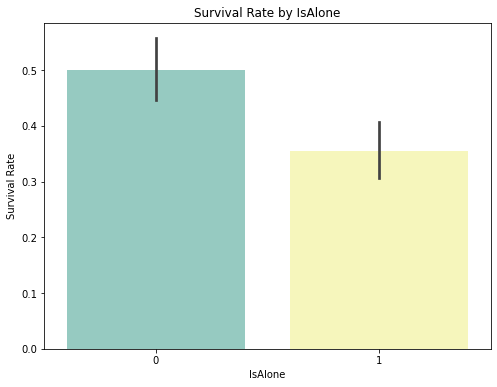

In [17]:
plt.figure(figsize=(8, 6))
sns.barplot(x="IsAlone", y="Survived", data=train_df, palette="Set3")
plt.title("Survival Rate by IsAlone")
plt.xlabel("IsAlone")
plt.ylabel("Survival Rate")
plt.show()

## Data Handling

Our dataset contains 6 feature columns:

- 2 continuous variables: 'Age' and 'Fare'
- 2 binary variables: 'IsAlone' and 'Sex'
- 1 ordinal categorical variable: 'Pclass'
- 1 non-ordinal categorical variable: 'Embarked'

We need to address missing values and preprocess the continuous variables 'Age' and 'Fare', as well as the non-ordinal categorical variable 'Embarked'. The binary variables and 'Pclass' do not require additional processing.

### We will create a copy of our data frames for further analysis to keep them separate from the optimal permutation search.

In [18]:
train_df_copy = train_df.copy()
test_df_copy= test_df.copy()

### Performing one-hot encoding for Embarked column

In [19]:
train_df_copy = pd.get_dummies(train_df, columns=['Embarked'], prefix='Embarked')
test_df_copy = pd.get_dummies(test_df, columns=['Embarked'], prefix='Embarked')

### Standardizing the 'Age' and 'Fare' columns.

In [20]:
numeric_features = ['Age', 'Fare']
scaler = StandardScaler()
train_df_copy[numeric_features] = scaler.fit_transform(train_df_copy[numeric_features])
test_df_copy[numeric_features] = scaler.transform(test_df_copy[numeric_features])

### Splitting the data to train and test set for using machine learning models

In [21]:
x_train_copy= train_df_copy.drop(columns=['Survived'])
y_train_copy = train_df_copy['Survived']

In [22]:
x_test_copy = test_df_copy.drop(columns=['Survived'])
y_test_copy= test_df_copy['Survived']

## Part 3 - Experiments
You could add as many code cells as needed

## First model : KNN

In [23]:
knn = KNeighborsClassifier(n_neighbors=100,p=1)  
knn.fit(x_train_copy, y_train_copy)
y_pred = knn.predict(x_test_copy)
f1 = f1_score(y_test_copy, y_pred)
print("F1 Score:", f1)

F1 Score: 0.7058823529411764


Not very satisfaing, let's try another model.

## Second model: Random Forest

We ensure consistent results by setting the random seed to 100 using the random_state parameter. We also create a forest of 200 trees with the n_estimators parameter and limit the maximum depth of each tree to 3 using the max_depth parameter.

In [24]:
rf_classifier = RandomForestClassifier(max_depth=3,n_estimators=200,random_state=100)
rf_classifier.fit(x_train_copy, y_train_copy)
y_pred = rf_classifier.predict(x_test_copy)
f1 = f1_score(y_test_copy, y_pred)
print("F1 Score:", f1)

F1 Score: 0.7547169811320755


Random Forest achieved higher f1 score than knn.

### Feature Importance

To improve our model's performance, we'll focus on training it with the most influential features. First, we need to identify these key features:


In [25]:
feature_names = x_train_copy.columns
feature_importances = rf_classifier.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
feature_importance_df = pd.DataFrame({'Feature': feature_names[sorted_indices],'Importance': feature_importances[sorted_indices]})
feature_importance_df

,Feature,Importance
0,Sex,0.493729
1,Pclass,0.189278
2,Fare,0.162505
3,Age,0.096735
4,Embarked_1,0.023881
5,IsAlone,0.018194
6,Embarked_0,0.009964
7,Embarked_2,0.005057
8,Embarked_3,0.000658


### This diagram shows the importance of each feature in the Random Forest classifier, with taller bars representing features that have a greater impact on the model's predictions.

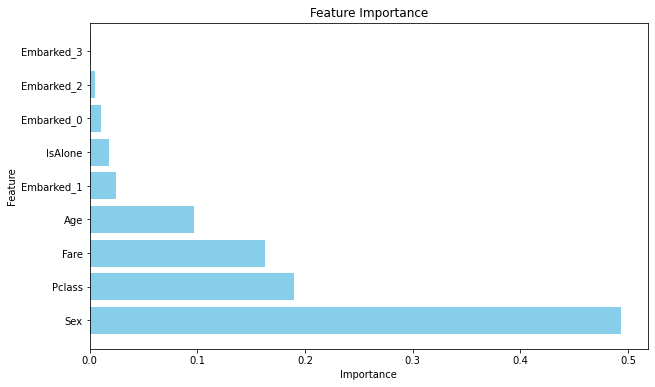

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')

ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Feature Importance')

plt.show()

#### We will train our model using only the top 4 most significant features: 'Sex', 'Pclass', 'Fare', and 'Age'.


In [27]:
top_features = feature_names[sorted_indices[:4]]

x_train_top = x_train_copy[top_features]
x_test_top = x_test_copy[top_features]

rf_classifier_top = RandomForestClassifier(max_features='sqrt', max_depth=3, n_estimators=200, random_state=100)
rf_classifier_top.fit(x_train_top, y_train_copy)

y_pred_top = rf_classifier_top.predict(x_test_top)
f1_top = f1_score(y_test_copy, y_pred_top)
print("F1 Score on Test Set (using only top 4 features):", f1_top)


F1 Score on Test Set (using only top 4 features): 0.7321428571428572


The decrease in score suggests that we might have lost crucial information necessary for accurate predictions by training the model only on the top 4 features.


## Third model: Gradient Boosting

Gradient Boosting captures complex relationships between features and the target variable, which is crucial for our prediction. Additionally, Gradient Boosting is robust to outliers and noisy data, making it suitable for real-world datasets like ours. We ensure consistent results also in this model by setting the random seed to 100 using the parameter random_state. In addition, we construct a forest of 300 trees, specifying n_estimators, and limit the maximum depth of each tree to 6 with the parameter max_depth.

In [28]:
gb_classifier = GradientBoostingClassifier(max_depth=6,n_estimators=300,random_state=100)

gb_classifier.fit(x_train_copy, y_train_copy)
y_pred = gb_classifier.predict(x_test_copy)

f1 = f1_score(y_test_copy, y_pred)
print("F1 Score:", f1)

F1 Score: 0.8


We got 80%

## Finding the best model & parameters permutation

In [29]:
X_train= train_df.drop(columns=['Survived'])
y_train = train_df['Survived']

In [30]:
X_test = test_df.drop(columns=['Survived'])
y_test= test_df['Survived']

### Defining to each feature the proper scaling

In [31]:
numeric_features = ['Age', 'Fare']
categorical_features = ['Embarked']
unchanged_features = ['Sex', 'IsAlone', 'Pclass']

In [32]:
# Assuming you have defined X_train, y_train, numeric_features, categorical_features, unchanged_features

scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'None': 'passthrough'  # Adding 'None' option for no scaling
}

results = []

# Running on all Scalers & Models & Params with grid search
for scaler_name, scaler in scalers.items():
    if scaler_name == 'None':
        numeric_transformer = 'passthrough'  # No scaling applied
    else:
        numeric_transformer = Pipeline(steps=[
            ('scaler', scaler)
        ])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('unchanged', 'passthrough', unchanged_features)
    ])

    models = {
        'RandomForestClassifier': {
            'model': RandomForestClassifier(random_state=100),
            'params': {
                'classifier__n_estimators': np.arange(50, 301, 50),
                'classifier__max_depth': [10, 20, 30, None],
                'classifier__min_samples_split': [2, 5, 10],
                'classifier__min_samples_leaf': [1, 2, 4]
            }
        },
        'GradientBoostingClassifier': {
            'model': GradientBoostingClassifier(random_state=100),
            'params': {
                'classifier__n_estimators': np.arange(100, 401, 100),
                'classifier__learning_rate': [0.01, 0.05, 0.1],
                'classifier__max_depth': [3, 4, 5, 6],
            }
        },
        'KNeighborsClassifier': {
            'model': KNeighborsClassifier(),
            'params': {
                'classifier__n_neighbors': np.arange(1, 31),
                'classifier__weights': ['uniform', 'distance'],
                'classifier__metric': ['euclidean', 'manhattan']
            }
        }
    }

    for model_name, mp in models.items():
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', mp['model'])
        ])

        search = GridSearchCV(pipe, mp['params'], cv=5, scoring='f1', return_train_score=True)
        search.fit(X_train, y_train)

        for i, params in enumerate(search.cv_results_['params']):
            results.append({
                'Model': model_name,
                'Scaler': scaler_name if scaler_name != 'None' else 'None',
                'Params': params,
                'Mean Test Score': search.cv_results_['mean_test_score'][i],
                'Std Test Score': search.cv_results_['std_test_score'][i]
            })

# Creating the DataFrame with all the results
all_results_df = pd.DataFrame(results)
all_results_df

,Model,Scaler,Params,Mean Test Score,Std Test Score
0,RandomForestClassifier,StandardScaler,"{'classifier__max_depth': 10, 'classifier__min...",0.695262,0.051826
1,RandomForestClassifier,StandardScaler,"{'classifier__max_depth': 10, 'classifier__min...",0.701384,0.062427
2,RandomForestClassifier,StandardScaler,"{'classifier__max_depth': 10, 'classifier__min...",0.701646,0.055617
3,RandomForestClassifier,StandardScaler,"{'classifier__max_depth': 10, 'classifier__min...",0.712749,0.050035
4,RandomForestClassifier,StandardScaler,"{'classifier__max_depth': 10, 'classifier__min...",0.708115,0.050372
...,...,...,...,...,...
1147,KNeighborsClassifier,None,"{'classifier__metric': 'manhattan', 'classifie...",0.582850,0.036111
1148,KNeighborsClassifier,None,"{'classifier__metric': 'manhattan', 'classifie...",0.570787,0.051708
1149,KNeighborsClassifier,None,"{'classifier__metric': 'manhattan', 'classifie...",0.589719,0.028251
1150,KNeighborsClassifier,None,"{'classifier__metric': 'manhattan', 'classifie...",0.560769,0.061624



# Using transformation&scaling pre-pipeline
Finding the best permutation for each model

In [33]:
best_results = all_results_df.loc[all_results_df.groupby(['Model', 'Scaler'])['Mean Test Score'].idxmax()]
print("\nBest results for each model:")
best_results


Best results for each model:


,Model,Scaler,Params,Mean Test Score,Std Test Score
610,GradientBoostingClassifier,MinMaxScaler,"{'classifier__learning_rate': 0.01, 'classifie...",0.740869,0.041099
994,GradientBoostingClassifier,None,"{'classifier__learning_rate': 0.01, 'classifie...",0.740869,0.041099
226,GradientBoostingClassifier,StandardScaler,"{'classifier__learning_rate': 0.01, 'classifie...",0.740869,0.041099
719,KNeighborsClassifier,MinMaxScaler,"{'classifier__metric': 'manhattan', 'classifie...",0.695902,0.057164
1096,KNeighborsClassifier,None,"{'classifier__metric': 'manhattan', 'classifie...",0.620659,0.024410
332,KNeighborsClassifier,StandardScaler,"{'classifier__metric': 'manhattan', 'classifie...",0.695163,0.036423
486,RandomForestClassifier,MinMaxScaler,"{'classifier__max_depth': 20, 'classifier__min...",0.750050,0.049005
854,RandomForestClassifier,None,"{'classifier__max_depth': 20, 'classifier__min...",0.754325,0.048592
86,RandomForestClassifier,StandardScaler,"{'classifier__max_depth': 20, 'classifier__min...",0.752837,0.047148


## Finding the model with the best score

In [34]:
best_model = best_results.loc[best_results['Mean Test Score'].idxmax()]
print("\nBest model overall:")
best_model_df=pd.DataFrame([best_model])
best_model_df


Best model overall:


,Model,Scaler,Params,Mean Test Score,Std Test Score
854,RandomForestClassifier,None,"{'classifier__max_depth': 20, 'classifier__min...",0.754325,0.048592


In [35]:
print("\nBest model parameters:")
best_params = best_model_df['Params'].iloc[0]
print(best_params)


Best model parameters:
{'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 150}


## Part 4 - Training 
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 3)

In [36]:
#Getting the best model and scaler
best_model_name = best_model_df['Model'].iloc[0]
best_scaler_name = best_model_df['Scaler'].iloc[0]

if best_scaler_name == 'StandardScaler':
    best_scaler = StandardScaler()
elif best_scaler_name == 'MinMaxScaler':
    best_scaler = MinMaxScaler()
else:
    best_scaler=None
    

In [37]:
#removing the 'classifier__' prefix
best_params = {k.split('__')[1]: v for k, v in best_params.items()}

In [38]:
#Giving to the best model his parameters
if best_model_name == 'RandomForestClassifier':
    best_model_instance = RandomForestClassifier(random_state=100, **best_params)
elif best_model_name == 'GradientBoostingClassifier':
    best_model_instance = GradientBoostingClassifier(random_state=100, **best_params)
else:
    best_model_instance = KNeighborsClassifier(**best_params)

In [39]:
# Creating the pipeline with the final params 
final_pipe = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[('scaler', best_scaler)]), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('unchanged', 'passthrough', unchanged_features)
        ]
    )),
    ('classifier', best_model_instance)
])

#Training on the the last time
final_pipe.fit(X_train, y_train)

print("\nModel trained with best combination on entire training set.")


Model trained with best combination on entire training set.


## Part 5 - Apply on test and show model performance estimation

The final pipeline we created will predict the desired values using the specified feature engineering process.

In [40]:
#Predicting on the test set
y_pred = final_pipe.predict(X_test)

Printing the first 10 predicted classifications VS the real classifications

In [41]:
comparison_df = pd.DataFrame({'Actual': y_test[:10],'Predicted': y_pred[:10]})
comparison_df['Correct'] = comparison_df['Actual'] == comparison_df['Predicted']

print("Comparison of the first 10 values:")
comparison_df

Comparison of the first 10 values:


,Actual,Predicted,Correct
0,0,0,True
1,0,0,True
2,0,0,True
3,0,1,False
4,1,0,False
5,1,0,False
6,0,0,True
7,0,0,True
8,1,1,True
9,0,0,True


Showing the model's performance report

In [42]:
#Evaluating the model performance on the test set
print("\nClassification report on the test set:")
print(classification_report(y_test, y_pred, target_names=['Not Survived', 'Survived']))
classification_report(y_test, y_pred, target_names=['Not Survived', 'Survived'])


Classification report on the test set:
              precision    recall  f1-score   support

Not Survived       0.88      0.91      0.89       118
    Survived       0.81      0.75      0.78        61

    accuracy                           0.85       179
   macro avg       0.84      0.83      0.84       179
weighted avg       0.85      0.85      0.85       179



'              precision    recall  f1-score   support\n\nNot Survived       0.88      0.91      0.89       118\n    Survived       0.81      0.75      0.78        61\n\n    accuracy                           0.85       179\n   macro avg       0.84      0.83      0.84       179\nweighted avg       0.85      0.85      0.85       179\n'

In [43]:
#Evaluating the model's general F1 score
f1 = f1_score(y_test, y_pred)
print(f"\nOverall F1 score: {f1:.2f}")


Overall F1 score: 0.78
